In [1]:
import pandas as pd
import numpy as np

# Load Data

In [2]:
review_dt = pd.read_json("data/amazon_data/AMAZON_FASHION.json", lines=True)
meta_dt = pd.read_json("data/amazon_data/meta_AMAZON_FASHION.json", lines=True)

## Review Data

In [3]:
reviewer_k = 5
more_than_k_reviewer_boolean = review_dt["reviewerID"].value_counts()>= reviewer_k
more_than_k_reviewer_index = more_than_k_reviewer_boolean.index[more_than_k_reviewer_boolean]

meta_k = 10
more_than_k_asin_boolean = review_dt["asin"].value_counts() >= meta_k
more_than_k_asin_index = more_than_k_asin_boolean.index[more_than_k_asin_boolean]

keep_boolean = review_dt["reviewerID"].apply(lambda x: x in more_than_k_reviewer_index) & \
    review_dt["asin"].apply(lambda x: x in more_than_k_asin_index)

review_dt = review_dt[keep_boolean]
review_dt = review_dt[['overall', 'verified', 'reviewerID', 'asin', 'reviewText', "summary", "vote"]]
# review_dt = review_dt.drop(["reviewTime", "reviewerName", "unixReviewTime", "image", "style"], axis=1)
review_dt = review_dt.reset_index(drop=True)

## Meta Data

In [4]:
meta_dt = meta_dt[meta_dt["rank"].notna()]
meta_dt["rank"] = meta_dt["rank"].apply(lambda x: x[0] if type(x) == list else x)
meta_dt["rank"] = meta_dt["rank"].str.split("in").str[0].str.replace(",", "")
meta_dt["rank"] = meta_dt["rank"].str.split("#").apply(lambda x: x[0] if len(x)==1 else x[1])
meta_dt["rank"] = meta_dt["rank"].astype(float)
meta_dt = meta_dt[['title', 'brand', 'rank', 'asin', 'imageURL', 'description', 'price']]
meta_dt = meta_dt.reset_index(drop=True)

### Sales Rank

In [5]:
threshold_rank_percentage = 0.1
threshold_rank = np.quantile(meta_dt["rank"], threshold_rank_percentage)
meta_dt["top_selling"] = 0
meta_dt.loc[meta_dt["rank"] <= threshold_rank, "top_selling"] = 1
meta_dt["top_selling"] = 2 * meta_dt["top_selling"] - 1
meta_dt = meta_dt.drop("rank", axis=1)

In [6]:
final_data = review_dt.merge(meta_dt, on="asin", how="left")
final_data.head()

,overall,verified,reviewerID,asin,reviewText,summary,vote,title,brand,imageURL,description,price,top_selling
0,4,True,AAQO19HKS86MQ,B00008JOQI,Nice shirt,Four Stars,NaN,Paul Fredrick Men's Pinpoint Button Down Colla...,NaN,NaN,NaN,NaN,-1.0
1,4,True,AAQO19HKS86MQ,B00008JOQI,Nice shirt,Four Stars,NaN,Paul Fredrick Men's Pinpoint Button Down Colla...,NaN,NaN,NaN,NaN,-1.0
2,5,True,A3FOL5CECUQJKV,B0006HB4XE,"Since it was Gem Avenue, I knew I couldn't go ...","Perfect size, length, presentation",NaN,BOX1MM Nickel Free Italian Sterling Silver 1mm...,NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,1.0
3,5,True,AQG16QCMT344N,B0007MV6PO,We gave this to an elder farmer friend and he ...,"Great hat for fishing and farming, and looks s...",NaN,"Henschel Breezer Hat with CoolMax Band Khaki,M...",Henschel,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,1.0
4,5,True,A2R0KB6P9AWB3N,B0008F6WMM,The helmet is a bit big for my 6 yr old. But i...,"But it is really nice, and looks awesome",NaN,Aeromax Jr. Astronaut Helmet with sounds,Aeromax,[https://images-na.ssl-images-amazon.com/image...,[The Aeromax Award winning Jr. Astronaut Helme...,$41.63,1.0


## Features for Reviewer

In [7]:
final_data["vote"] = final_data["vote"].fillna(0)
reviewer_mean_upvote_series = final_data.groupby("reviewerID")["vote"].mean()
reviewer_mean_upvote_series.name = "upvote_per_review"
reviewer_mean_upvote_series.describe()

count    3600.000000
mean        0.930573
std         4.094084
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max       158.000000
Name: upvote_per_review, dtype: float64

In [8]:
summary_length_series = final_data["summary"].apply(lambda x: len(x) if x is not np.nan else x)
summary_length_series = summary_length_series.fillna(0)
summary_length_series = summary_length_series.groupby(final_data["reviewerID"]).mean()
summary_length_series.name = "mean_summary_length"

In [9]:
summary_length_series.describe()

count    3600.000000
mean       20.928749
std        14.873483
min         0.000000
25%        10.000000
50%        15.732143
75%        26.687500
max       111.000000
Name: mean_summary_length, dtype: float64

In [10]:
review_length_series = final_data["reviewText"].apply(lambda x: len(x) if x is not np.nan else x)
review_length_series = review_length_series.fillna(0)
review_length_series = review_length_series.groupby(final_data["reviewerID"]).mean()
review_length_series.name = "mean_review_length"

In [11]:
review_length_series.describe()

count    3600.000000
mean      181.431642
std       271.441992
min         0.000000
25%        36.600000
50%        92.242424
75%       196.425000
max      2973.000000
Name: mean_review_length, dtype: float64

In [12]:
reviewer_feature_dt = pd.concat([reviewer_mean_upvote_series, 
                                 review_length_series, summary_length_series], 
                                axis=1)

In [13]:
final_data = final_data.merge(reviewer_feature_dt, 
                              left_on="reviewerID", right_index=True).drop("vote", axis=1)
del reviewer_feature_dt

In [14]:
final_data[["summary", "reviewText"]] = final_data[["summary", "reviewText"]].fillna("")
final_data["summary_review"] = final_data["summary"] + " " + final_data["reviewText"]
final_data = final_data.drop(["summary", "reviewText"], axis=1)
final_data["summary_review"] = final_data["summary_review"].apply(lambda x: [x])
final_data["title"] = final_data["title"].apply(lambda x: [x])

In [15]:
final_data.isna().mean()

overall                0.000000
verified               0.000000
reviewerID             0.000000
asin                   0.000000
title                  0.000000
brand                  0.469145
imageURL               0.120346
description            0.639683
price                  0.562005
top_selling            0.028205
upvote_per_review      0.000000
mean_review_length     0.000000
mean_summary_length    0.000000
summary_review         0.000000
dtype: float64

In [16]:
final_data["verified"].mean()

0.9208821412211242

In [17]:
final_data = final_data.dropna(subset=["title", "imageURL"])
final_data = final_data.drop(["description", "brand", "price"],axis=1)
final_data = final_data.reset_index(drop=True)

In [18]:
final_data.isna().mean()

overall                0.0
verified               0.0
reviewerID             0.0
asin                   0.0
title                  0.0
imageURL               0.0
top_selling            0.0
upvote_per_review      0.0
mean_review_length     0.0
mean_summary_length    0.0
summary_review         0.0
dtype: float64

## Response Variable

### Rating

In [19]:
rating_array = np.zeros(final_data.shape[0])
rating_array[final_data["overall"] >= 4] = 1
rating_series = 2 * pd.Series(rating_array, name="rating") - 1
rating_series.value_counts()

 1.0    10467
-1.0     2975
Name: rating, dtype: int64

In [20]:
final_data["overall"].value_counts()

5    7894
4    2573
3    1459
1     819
2     697
Name: overall, dtype: int64

In [21]:
final_data["rating"] = rating_series
del rating_series, rating_array

In [22]:
final_data["rating"].value_counts(normalize=True)

 1.0    0.778679
-1.0    0.221321
Name: rating, dtype: float64

In [23]:
final_data["top_selling"].value_counts(normalize=True)

 1.0    0.864232
-1.0    0.135768
Name: top_selling, dtype: float64

In [24]:
# add distribution of reviewer's review
import itertools
reviewer_rating_pair_list = list(itertools.product(final_data["reviewerID"].unique(), [5, 4, 3, 2, 1]))
review_distribution_series = final_data.groupby("reviewerID")["overall"].value_counts(normalize=True).reindex(
    reviewer_rating_pair_list,fill_value=0)
review_distribution_series.name = "review_distribution"
review_distribution_dt = review_distribution_series.reset_index()
del reviewer_rating_pair_list, review_distribution_series
review_distribution_dt = pd.pivot_table(review_distribution_dt, 
                                        values="review_distribution", 
                                        index="reviewerID", columns="overall")

In [25]:
review_distribution_dt.head()

overall,1,2,3,4,5
reviewerID,,,,,
A0986263H7SX62P1SRDD,0.000000,0.000000,0.0,0.166667,0.833333
A101HTPLV9HVMR,0.000000,0.000000,0.0,0.000000,1.000000
A104M4DKQ96IT0,0.000000,0.000000,0.0,1.000000,0.000000
A10B949WG5N4GH,0.666667,0.333333,0.0,0.000000,0.000000
A10E3QH2FQUBLF,0.000000,0.000000,0.5,0.500000,0.000000


In [26]:
review_distribution_dt.columns = ["d1", "d2", "d3", "d4", "d5"]
final_data = final_data.merge(review_distribution_dt, left_on="reviewerID", right_index=True)
del review_distribution_dt

In [27]:
final_data.shape

(13442, 17)

In [28]:
final_data.head(3)

,overall,verified,reviewerID,asin,title,imageURL,top_selling,upvote_per_review,mean_review_length,mean_summary_length,summary_review,rating,d1,d2,d3,d4,d5
0,3,True,AAQO19HKS86MQ,B00IQZZ9JI,[Yazilind Jewelry Elegant Bronze Alloy Cinnamo...,[https://images-na.ssl-images-amazon.com/image...,1.0,0.0,55.2,22.4,[The pictures you have on the site looks like ...,-1.0,0.0,0.0,0.666667,0.0,0.333333
1,5,True,AAQO19HKS86MQ,B00KA3UV0Q,[Qiyun (TM) Graffiti Art Deco Filigree Hollow ...,[https://images-na.ssl-images-amazon.com/image...,1.0,0.0,55.2,22.4,[Five Stars Is beautiful and I am very pleased...,1.0,0.0,0.0,0.666667,0.0,0.333333
2,3,True,AAQO19HKS86MQ,B00KW4L9XQ,[Chunky Twist Tribal Antique Gold Bib Statemen...,[https://images-na.ssl-images-amazon.com/image...,1.0,0.0,55.2,22.4,"[Three Stars Not so good in person , but accep...",-1.0,0.0,0.0,0.666667,0.0,0.333333


In [29]:
import matplotlib.pyplot as plt

In [30]:
dfp = final_data[["top_selling", "rating"]].pivot_table(index='top_selling', 
                                                  columns="rating", values="rating", aggfunc='size')
dfp

rating,-1.0,1.0
top_selling,,
-1.0,505,1320
1.0,2470,9147


<AxesSubplot:xlabel='top_selling'>

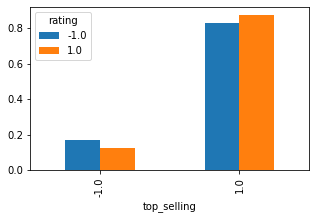

In [31]:
(dfp / dfp.sum(axis=0)).plot(kind='bar', figsize=(5, 3))

In [32]:
x_y_mat = final_data[["top_selling", "rating"]].to_numpy()

In [33]:
continuous_feature_name_list = ["upvote_per_review", "mean_review_length", "mean_summary_length", "d1",
                               "d2", "d3", "d4", "d5"]
continuous_feature_mat = final_data[continuous_feature_name_list].to_numpy()
categorical_feature_mat = final_data["verified"].astype(int).to_numpy()

## Create TF Dataset

## Train Test Split

In [34]:
from sklearn.model_selection import train_test_split
indices_array = np.arange(final_data.shape[0])
train_indices_array, test_indices_array = train_test_split(indices_array, 
                                                           stratify=final_data[["top_selling", "rating"]],
                                                           test_size=0.1, 
                                                           random_state=0)

In [35]:
train_indices_array, val_indices_array = train_test_split(
    train_indices_array, stratify=final_data.loc[train_indices_array, ["top_selling", "rating"]],
    test_size=0.1, random_state=0
)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_continuous_feature_mat = scaler.fit_transform(continuous_feature_mat[train_indices_array, :])
val_continuous_feature_mat = scaler.transform(continuous_feature_mat[val_indices_array, :])
test_continuous_feature_mat = scaler.transform(continuous_feature_mat[test_indices_array, :])

train_feature_mat = np.concatenate([train_continuous_feature_mat, 
                                    categorical_feature_mat[train_indices_array].reshape(-1, 1)], 
                                   axis=1)
val_feature_mat = np.concatenate([val_continuous_feature_mat, 
                                  categorical_feature_mat[val_indices_array].reshape(-1, 1)], 
                                 axis=1)
test_feature_mat = np.concatenate([test_continuous_feature_mat, 
                                  categorical_feature_mat[test_indices_array].reshape(-1, 1)], 
                                 axis=1)

del train_continuous_feature_mat, val_continuous_feature_mat, test_continuous_feature_mat

In [37]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({"title": final_data["title"][train_indices_array].to_list(), "numeric_feature": train_feature_mat},
    x_y_mat[train_indices_array, :])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ({"title": final_data["title"][val_indices_array].to_list(), "numeric_feature": val_feature_mat},
    x_y_mat[val_indices_array, :])
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    ({"title": final_data["title"][test_indices_array].to_list(), "numeric_feature": test_feature_mat},
    x_y_mat[test_indices_array, :])
)

2022-05-29 22:36:36.529775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model

In [39]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"] 
# sequence_output = outputs["sequence_output"]

pooled_output = tf.keras.layers.Dense(units=128, activation="elu")(pooled_output)
embedding_model = tf.keras.Model(text_input, pooled_output)

In [40]:
import adult_data_functions as af

class ModelNetwork(tf.keras.Model):
    # This is the class network we fit on the data.
    def __init__(self, n_layers, hidden_dim, l_dim, output_dim, title_model, l2=0):
        super(ModelNetwork, self).__init__()

        self.hidden_layer = af._create_connnected_block(n_layers=n_layers, hidden_dim=hidden_dim,
                                                     output_dim=l_dim,
                                                     l2=l2)
        self.title_model = title_model

        self.final_linear = tf.keras.layers.Dense(
            units=output_dim,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.L2(l2)
        )

    def call(self, inputs):
        embeded_title = self.title_model(inputs["title"])
        combined_feature = tf.concat([embeded_title, ], axis=1)
        output = combined_feature
        if self.hidden_layer is not None:
            for layer in self.hidden_layer:
                output = layer(output)
        output = self.final_linear(output)

        return output

# Training

In [41]:
from sklearn.metrics import f1_score, accuracy_score

class Metric(tf.keras.metrics.Metric):
    def __init__(self, name, response_name, **kwargs):
        self.response_name = response_name
        super().__init__(name=f"{name}_{response_name}", **kwargs)
        self.score = self.add_weight(name=f"{name}_{response_name}", initializer="zeros")
        if name == "f1":
            self.metric = f1_score
        else:
            self.metric = accuracy_score

    def update_state(self, y_true, y_pred, sample_weight=None):
        """

        :param y_true: An array. Storing the x_y_mat.
        :param y_pred: A tensor. J parameters of the Ising Model
        :param sample_weight:
        :return:
        """
        x_y_pred_array = af.ising_predict(parameter_mat=y_pred, prob_boolean=False)

        # we made class we want to calculate based on to have label 1.
        if self.response_name == "top_selling":
            class_score = self.metric(y_true=-y_true[:, 0], y_pred=-x_y_pred_array[:, 0], sample_weight=sample_weight)
        else:
            class_score = self.metric(y_true=-y_true[:, 1], y_pred=-x_y_pred_array[:, 1], sample_weight=sample_weight)
        self.score.assign(class_score)

    def result(self):
        return self.score

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.score.assign(0.0)

f1_sex_metric = Metric(name="f1", response_name="top_selling")
f1_income_metric = Metric(name="f1", response_name="rating")
accuracy_sex_metric = Metric(name="accuracy", response_name="top_selling")
accuracy_income_metric = Metric(name="accuracy", response_name="rating")

In [42]:
l2 = 0
epochs=10
model = ModelNetwork(n_layers=0, hidden_dim=140, l_dim=140, output_dim=2, l2=l2, title_model=embedding_model)

# learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[10, 15], 
#                                                                      values=[0.1, 0.01, 0.001])
learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=af.ising_likelihood, 
              metrics=[f1_sex_metric, f1_income_metric, accuracy_sex_metric, accuracy_income_metric],
             run_eagerly=True)

buffer_size = 50000
batch_size = 200
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)

In [43]:
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 1.3149 - f1_top_selling: 0.0000e+00 - f1_rating: 0.0000e+00 - accuracy_top_selling: 0.8851 - accuracy_rating: 0.6897

ValueError: in user code:

    File "/Users/xw/Documents/PycharmProjects/Conditional_Independence_Test/adult_data_functions.py", line 262, in ising_likelihood  *
        return gt.log_ising_likelihood(x_y_mat=y_true, parameter_mat=y_pred, reduce_boolean=True) / y_true.shape[0]
    File "/Users/xw/Documents/PycharmProjects/Conditional_Independence_Test/generate_train_functions.py", line 97, in log_ising_likelihood  *
        x_times_y = x_y_mat[:, 0] * x_y_mat[:, 1]

    ValueError: slice index 1 of dimension 1 out of bounds. for '{{node strided_slice_2}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2](y_true, strided_slice_2/stack, strided_slice_2/stack_1, strided_slice_2/stack_2)' with input shapes: [2,1], [2], [2], [2] and with computed input tensors: input[1] = <0 1>, input[2] = <0 2>, input[3] = <1 1>.
